# 2 Graph-SLAM 2D

## 2.1 Función para leer el conjunto de datos Intel 2D

In [47]:
#corroboro que este instalado gtsam, que este bien seleccionado el interprete de python y el kernel de jupyter

import gtsam
from gtsam import Pose2, BetweenFactorPose2, noiseModel

#Creo un ejemplo para probar la biblioteca
# Crear un Pose2
p = Pose2(1, 2, 0.5)
print("Pose2:", p)

# Crear un factor de ejemplo (ruido gaussiano unitario)
prior_noise = noiseModel.Diagonal.Sigmas([0.1, 0.1, 0.1])
factor = BetweenFactorPose2(1, 2, Pose2(0.5, 0.5, 0.1), prior_noise)
print("Factor creado:", factor)



Pose2: (1, 2, 0.5)

Factor creado: BetweenFactor(1,2)
  measured:  (0.5, 0.5, 0.1)
isotropic dim=3 sigma=0.1



In [ ]:
# dependencias y lector G2O (si ya lo tenés, ok)
#matplotlib.use("Agg")   # seguro para WSL/servidores; cambiar si necesitás mostrar inline
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

# lector G2O simple
def read_intel_g2o(filename):
    """
    Lee un archivo .g2o y devuelve listas de poses y aristas.
    Pose: {'id': i, 'x': x, 'y': y, 'theta': theta}
    Edge: {'from': i, 'to': j, 'dx': dx, 'dy': dy, 'dtheta': dtheta, 'info': Omega}
    """
    poses = []
    edges = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts: 
                continue
            tag = parts[0]
            if tag == 'VERTEX_SE2':
                i = int(parts[1])
                x, y, theta = float(parts[2]), float(parts[3]), float(parts[4])
                poses.append({'id': i, 'x': x, 'y': y, 'theta': theta})
            elif tag == 'EDGE_SE2':
                i, j = int(parts[1]), int(parts[2])
                dx, dy, dtheta = float(parts[3]), float(parts[4]), float(parts[5])
                q = list(map(float, parts[6:12]))
                # Matriz de información (triangular superior => reconstruir simétrica)
                q11, q12, q13, q22, q23, q33 = q
                Omega = np.array([[q11, q12, q13],
                                  [q12, q22, q23],
                                  [q13, q23, q33]])
                edges.append({'from': i, 'to': j, 'dx': dx, 'dy': dy, 'dtheta': dtheta, 'info': Omega})
    return poses, edges

# Ajustar la ruta del archivo .g2o aquí
g2o_path = 'input_INTEL_g2o.g2o'
if not os.path.exists(g2o_path):
    raise FileNotFoundError(f"No encuentro el archivo {g2o_path}. Ajustá g2o_path a la ruta correcta.")
poses,edges=read_intel_g2o(g2o_path)
print(f"Leí {len(poses)} poses y {len(edges)} aristas del archivo G2O.")

Leí 1228 poses y 1483 aristas del archivo G2O.


In [49]:
poses, edges = read_intel_g2o('input_INTEL_g2o.g2o')
print(len(poses), "poses leídas")
print(len(edges), "aristas leídas")
print(poses[0])
print(edges[0])


1228 poses leídas
1483 aristas leídas
{'id': 0, 'x': 0.0, 'y': 0.0, 'theta': 0.0}
{'from': 0, 'to': 1, 'dx': 0.0, 'dy': 0.0, 'dtheta': -0.000642, 'info': array([[ 1.11112710e+01, -2.49667000e-01,  0.00000000e+00],
       [-2.49667000e-01,  3.99999840e+02,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.49679309e+03]])}


## 2.2 Batch Solution

In [50]:
# construir el grafo en GTSAM y optimizar con Gauss-Newton
# Requiere gtsam instalado en tu entorno (pip install gtsam o conda, según tu setup)
import gtsam
from gtsam import Pose2, noiseModel, BetweenFactorPose2, NonlinearFactorGraph, Values
# optimizador
from gtsam import GaussNewtonOptimizer, GaussNewtonParams
import numpy as np
# Pruebo otro optimizador a ver si obtengo buenos resultados
from gtsam import LevenbergMarquardtOptimizer, LevenbergMarquardtParams

poses_list, edges_list = read_intel_g2o(g2o_path)

# Construir grafo y valores iniciales
graph = NonlinearFactorGraph()
initial = Values()

# Insertar poses iniciales (las ids pueden no ser consecutivas)
for p in poses_list:
    pid = int(p['id'])
    initial.insert(pid, Pose2(p['x'], p['y'], p['theta']))

# Añadir prior en el primer nodo leído (para "fijar" el marco)
# Si querés otro nodo como origen, cambiá prior_id
prior_id = poses_list[0]['id']
prior_pose = Pose2(poses_list[0]['x'], poses_list[0]['y'], poses_list[0]['theta'])
prior_cov = np.diag([1e-6, 1e-6, 1e-8])  # alta confianza (fija prácticamente la primera pose)
prior_noise = noiseModel.Gaussian.Covariance(prior_cov)
graph.add(gtsam.PriorFactorPose2(prior_id, prior_pose, prior_noise))

# Añadir factores Between a partir de las aristas leídas
for e in edges_list:
    i = int(e['from'])
    j = int(e['to'])
    dx, dy, dtheta = e['dx'], e['dy'], e['dtheta']
    Omega = np.array(e['info'])
    # invertimos la información para obtener la covarianza (si Omega es singular, regularizar)
    # regularización ligera para evitar problemas numéricos:
    eps = 1e-9
    try:
        cov = np.linalg.inv(Omega)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(Omega) + eps * np.eye(3)
    # En GTSAM la covarianza para noiseModel.Gaussian.Covariance espera matriz 3x3
    model = noiseModel.Gaussian.Covariance(cov)
    between = BetweenFactorPose2(i, j, Pose2(dx, dy, dtheta), model)
    graph.add(between)

# Guardar la trayectoria inicial para graficar (ordenadas por id ascendente)
ids_sorted = sorted([p['id'] for p in poses_list])
x_init = [initial.atPose2(int(i)).x() for i in ids_sorted]
y_init = [initial.atPose2(int(i)).y() for i in ids_sorted]

#agrego modelo con perturbación para ver si no quedo atrapado en un minimo local
delta = 0.05  # magnitud de la perturbación
initial_perturbed = Values()
for p in poses_list:
    pid = int(p['id'])
    x_pert = p['x'] + np.random.uniform(-delta, delta)
    y_pert = p['y'] + np.random.uniform(-delta, delta)
    theta_pert = p['theta'] + np.random.uniform(-delta, delta)
    initial_perturbed.insert(pid, Pose2(x_pert, y_pert, theta_pert))

# Parámetros del optimizador Gauss-Newton
params = GaussNewtonParams()
params.setMaxIterations(100)
params.setRelativeErrorTol(1e-6)
params.setVerbosity('ERROR')  

optimizer = GaussNewtonOptimizer(graph, initial, params)
result = optimizer.optimize()

# Trayectoria optimizada
x_opt = [result.atPose2(int(i)).x() for i in ids_sorted]
y_opt = [result.atPose2(int(i)).y() for i in ids_sorted]

print("Optimización completada.")

#optimización con perturbación
optimizer_pert = GaussNewtonOptimizer(graph, initial_perturbed, params)
result_pert = optimizer_pert.optimize()
x_opt_pert = [result_pert.atPose2(int(i)).x() for i in ids_sorted]
y_opt_pert = [result_pert.atPose2(int(i)).y() for i in ids_sorted]
print("Optimización con perturbaciones completada.")

#optimización con solver mas robusto Levenberg-Marquardt
lparams = LevenbergMarquardtParams()
lparams.setMaxIterations(100)
optimizer = LevenbergMarquardtOptimizer(graph, initial, lparams)
lresult = optimizer.optimize()
x_lopt = [lresult.atPose2(int(i)).x() for i in ids_sorted]
y_lopt = [lresult.atPose2(int(i)).y() for i in ids_sorted]
print("Optimización Levenberg-Marquardt completada.")

Initial error: 2574860.52239
newError: 1546468706.53
errorThreshold: 1546468706.53 > 0
absoluteDecrease: -1543893846.01 < 1e-05
relativeDecrease: -599.602903762 < 1e-06
errorThreshold: 1546468706.53 <? 0
absoluteDecrease: -1543893846.01 <? 1e-05
relativeDecrease: -599.602903762 <? 1e-06
iterations: 1 >? 100
Optimización completada.
Optimización con perturbaciones completada.
Initial error: 2664142284.92
Optimización Levenberg-Marquardt completada.
newError: 5452738602.8
errorThreshold: 5452738602.8 > 0
absoluteDecrease: -2788596317.87 < 1e-05
relativeDecrease: -1.0467144843 < 1e-06
errorThreshold: 5452738602.8 <? 0
absoluteDecrease: -2788596317.87 <? 1e-05
relativeDecrease: -1.0467144843 <? 1e-06
iterations: 1 >? 100


grafica de resultados

Figura guardada: intel_traj_optimizada.png


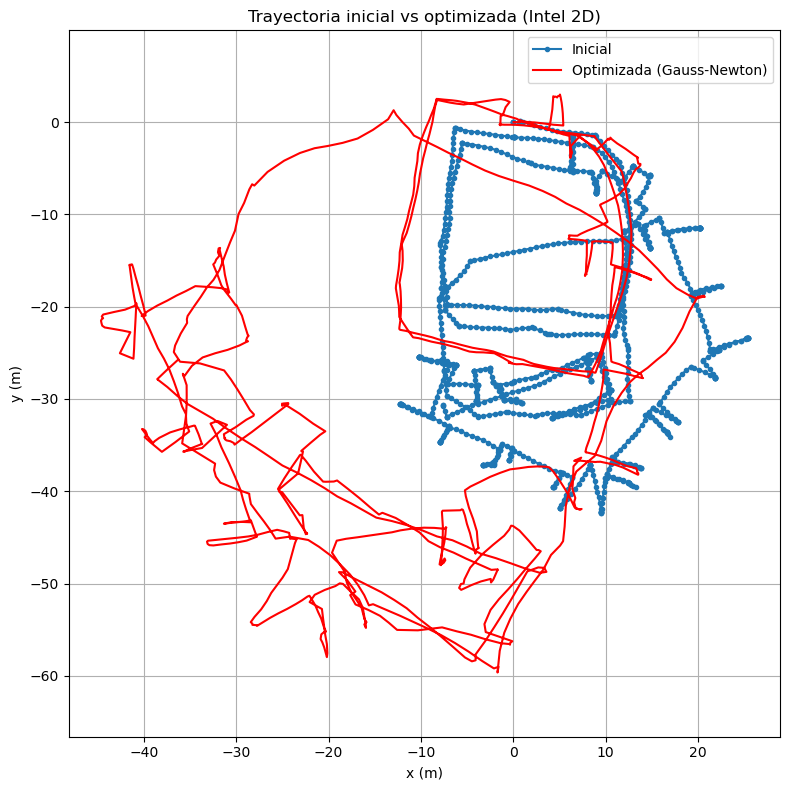

Figura guardada: intel_traj_optimizada_rev02.png


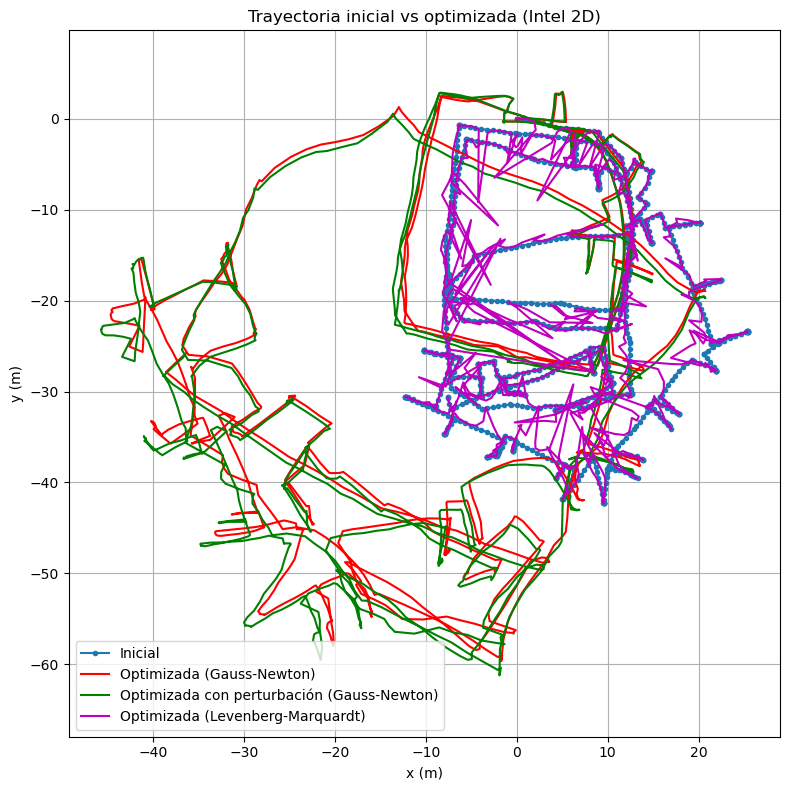

In [51]:
import matplotlib.pyplot as plt

# graficar y guardar figura solo con Gauss-Newton
plt.figure(figsize=(8,8))
plt.plot(x_init, y_init, '-o', label='Inicial', markersize=3)
plt.plot(x_opt, y_opt, '-r', label='Optimizada (Gauss-Newton)', markersize=3)
plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Trayectoria inicial vs optimizada (Intel 2D)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Guardar figura para el informe
out_fig = 'intel_traj_optimizada.png'
plt.savefig(out_fig, dpi=200)
print(f"Figura guardada: {out_fig}")
plt.show()

# graficar y guardar figura con 3 métodos
plt.figure(figsize=(8,8))
plt.plot(x_init, y_init, '-o', label='Inicial', markersize=3)
plt.plot(x_opt, y_opt, '-r', label='Optimizada (Gauss-Newton)', markersize=3)
plt.plot(x_opt_pert, y_opt_pert, '-g', label='Optimizada con perturbación (Gauss-Newton)', markersize=3)
plt.plot(x_lopt, y_lopt, '-m', label='Optimizada (Levenberg-Marquardt)', markersize=3)
plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Trayectoria inicial vs optimizada (Intel 2D)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Guardar figura para el informe
out_fig = 'intel_traj_optimizada_rev02.png'
plt.savefig(out_fig, dpi=200)
print(f"Figura guardada: {out_fig}")
plt.show()


## 2.3 Incremental Solution

In [52]:
# ======================================
# Celda B: algoritmo incremental ISAM2
# ======================================
# Leemos datos
poses_list, edges_list = read_intel_g2o(g2o_path)

# Parámetros ISAM2
isam_params = gtsam.ISAM2Params()
# isam_params.relinearizeThreshold = 0.01
# isam_params.relinearizeSkip = 1
isam = gtsam.ISAM2(isam_params)

# Guardamos la trayectoria incremental (optimizada) por id
ids_sorted = sorted([p['id'] for p in poses_list])

# Mantendremos también valores iniciales (para graficar la inicial)
initial_values = gtsam.Values()
for p in poses_list:
    initial_values.insert(int(p['id']), Pose2(p['x'], p['y'], p['theta']))

# Resultado incremental (se va a ir actualizando)
result = gtsam.Values()

# opcional similar a ej anterior: magnitud de perturbación para evitar mínimos locales (setear a 0 para desactivar)
perturbation_sigma = 0.0  # ej. 1e-3 o 1e-2 si querés probar perturbaciones

# Iteramos poses siguiendo el pseudocódigo (cada iteración añadimos las aristas que terminan en el id actual)
for pose in poses_list:
    idp = int(pose['id'])
    # Crear grafo y valores para esta actualización
    graph = gtsam.NonlinearFactorGraph()
    initialEstimate = gtsam.Values()
    
    if idp == ids_sorted[0]:  # primer nodo (se asume que el primer id es el origen)
        prior_noise_cov = np.diag([1e-6, 1e-6, 1e-8])  # alta confianza en la primera pose
        prior_noise = noiseModel.Gaussian.Covariance(prior_noise_cov)
        prior_pose = Pose2(pose['x'], pose['y'], pose['theta'])
        graph.add(gtsam.PriorFactorPose2(idp, prior_pose, prior_noise))
        # insertar inicial tal cual
        initialEstimate.insert(idp, prior_pose)
    else:
        # intentamos recuperar la pose optimizada previa (result), si no existe, usamos la pose original
        try:
            prev_pose = result.atPose2(idp - 1)
            seed = Pose2(prev_pose.x(), prev_pose.y(), prev_pose.theta())
        except Exception:
            # fallback: usar la pose del archivo (si existe) o la última inicial conocida
            # buscamos la pose en poses_list
            found = next((pp for pp in poses_list if int(pp['id']) == idp), None)
            if found is not None:
                seed = Pose2(found['x'], found['y'], found['theta'])
            else:
                # fallback extra: usar cero
                seed = Pose2(0.0, 0.0, 0.0)
        # Aplicar una pequeña perturbación si se desea
        if perturbation_sigma > 0:
            seed = Pose2(seed.x() + np.random.randn() * perturbation_sigma,
                         seed.y() + np.random.randn() * perturbation_sigma,
                         seed.theta() + np.random.randn() * perturbation_sigma)
        initialEstimate.insert(idp, seed)
    
    # Añadir todas las aristas que tengan ide2 == idp (salientes hacia el nodo actual)
    for e in edges_list:
        if int(e['to']) == idp:
            ide1 = int(e['from'])
            ide2 = int(e['to'])
            dx, dy, dtheta = e['dx'], e['dy'], e['dtheta']
            Omega = np.array(e['info'])
            # construir covarianza = inv(Omega) con regularización numérica
            eps = 1e-9
            try:
                cov = np.linalg.inv(Omega)
            except np.linalg.LinAlgError:
                cov = np.linalg.pinv(Omega) + eps * np.eye(3)
            model = noiseModel.Gaussian.Covariance(cov)
            graph.add(gtsam.BetweenFactorPose2(ide1, ide2, Pose2(dx, dy, dtheta), model))
    
    # Actualizar ISAM2 con los factores y la estimación inicial de esta iteración
    isam.update(graph, initialEstimate)
    result = isam.calculateEstimate()  # obtener la estimación global actualizada

# Al final del bucle 'result' contiene la estimación ISAM2 final
print("ISAM2 update completado. Número de variables estimadas:", len(ids_sorted))


ISAM2 update completado. Número de variables estimadas: 1228


Figura guardada: intel_traj_isam2.png


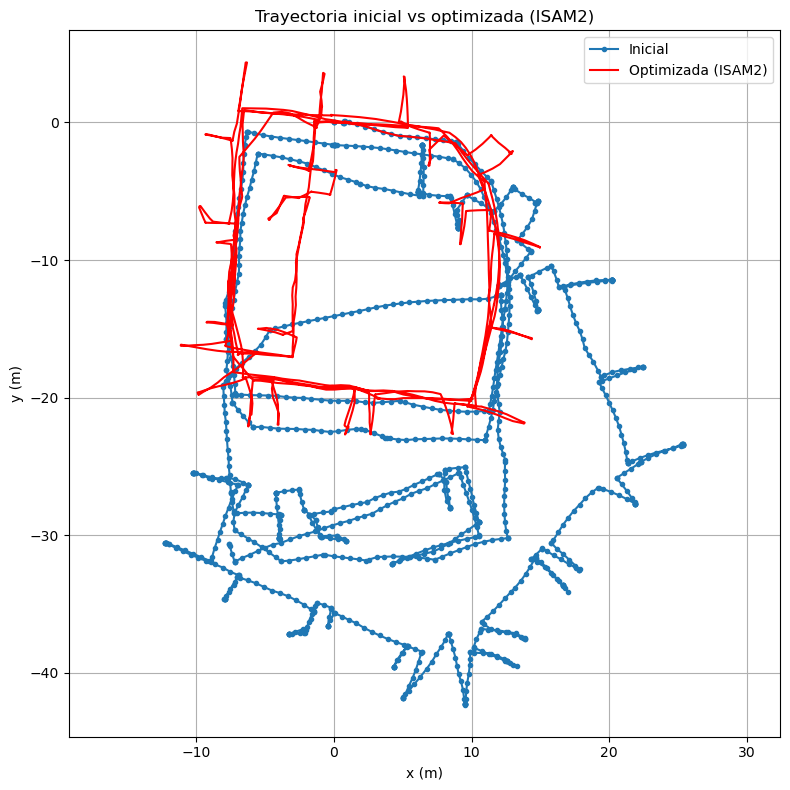

In [56]:
import matplotlib.pyplot as plt
# graficamos ambas trayectorias; original/incremental ISAM2
ids_sorted = sorted([p['id'] for p in poses_list])

x_init = [initial_values.atPose2(int(i)).x() for i in ids_sorted]
y_init = [initial_values.atPose2(int(i)).y() for i in ids_sorted]

x_isam = [result.atPose2(int(i)).x() for i in ids_sorted]
y_isam = [result.atPose2(int(i)).y() for i in ids_sorted]

# Graficar
plt.figure(figsize=(8,8))
plt.plot(x_init, y_init, '-o', label='Inicial', markersize=3)
plt.plot(x_isam, y_isam, '-r', label='Optimizada (ISAM2)', markersize=3)
plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Trayectoria inicial vs optimizada (ISAM2)')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Guardar figura
out_fig = 'intel_traj_isam2.png'
plt.savefig(out_fig, dpi=200)
print(f"Figura guardada: {out_fig}")
plt.show()



# 3  Graph-SLAM 3D
## 3.1 Función para leer el archivo 3D Garage G2O

In [36]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ---------- lector G2O 3D (VERTEX_SE3:QUAT, EDGE_SE3:QUAT) ----------
def read_garage_g2o_3d(filename):
    """
    Lee un archivo .g2o con datos 3D (VERTEX_SE3:QUAT y EDGE_SE3:QUAT)
    y devuelve listas de poses y aristas en formato manejable para GTSAM.
    
    Cada pose = {id, x, y, z, qx, qy, qz, qw}
    Cada edge = {from, to, x, y, z, qx, qy, qz, qw, info (6x6)}
    """
    poses = []
    edges = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            tag = parts[0]
            if tag == "VERTEX_SE3:QUAT":
                if len(parts) < 9: 
                    continue
                i = int(parts[1])
                x, y, z = map(float, parts[2:5])
                qx, qy, qz, qw = map(float, parts[5:9])
                poses.append({'id': i, 'x': x, 'y': y, 'z': z,
                              'qx': qx, 'qy': qy, 'qz': qz, 'qw': qw})
            elif tag == "EDGE_SE3:QUAT":
                # línea típica: EDGE_SE3:QUAT i j x y z qx qy qz qw [21 info vals]
                if len(parts) < 31:
                    continue
                i, j = int(parts[1]), int(parts[2])
                x, y, z = map(float, parts[3:6])
                qx, qy, qz, qw = map(float, parts[6:10])
                info_vec = list(map(float, parts[10:31]))  # 21 valores
                # construir matrix 6x6 desde triangular superior (21 elementos)
                I = np.zeros((6,6))
                tri_idx = np.triu_indices(6)
                I[tri_idx] = info_vec
                I = I + np.triu(I, 1).T
                edges.append({'from': i, 'to': j,
                              'x': x, 'y': y, 'z': z,
                              'qx': qx, 'qy': qy, 'qz': qz, 'qw': qw,
                              'info': I})
    return poses, edges



Ejemplo de uso

In [37]:
g2o_3d_path = "parking-garage.g2o"
poses3d, edges3d = read_garage_g2o_3d(g2o_3d_path)

print(f"Leídas {len(poses3d)} poses y {len(edges3d)} aristas.")
print("Primera pose:", poses3d[0])
print("Primera arista info(0,0):", edges3d[0]['info'][0,0])


Leídas 1661 poses y 6275 aristas.
Primera pose: {'id': 0, 'x': 0.0, 'y': 0.0, 'z': 0.0, 'qx': 0.0, 'qy': 0.0, 'qz': 0.0, 'qw': 1.0}
Primera arista info(0,0): 1.0


## 3.2 Batch Solution

In [ ]:

# ---------- Ajustar ruta del archivo .g2o ----------
g2o_path = 'parking-garage.g2o' 
if not os.path.exists(g2o_path):
    raise FileNotFoundError(f"No encuentro {g2o_path}. Pon la ruta correcta en g2o_path.")

import gtsam
from gtsam import Pose3, Rot3, Point3, noiseModel
import matplotlib.pyplot as plt

# ---------- Leer datos ----------
poses3d, edges3d = read_garage_g2o_3d(g2o_path)
if len(poses3d) == 0:
    raise RuntimeError("No se detectaron VERTEX_SE3:QUAT en el archivo.")

ids_sorted = sorted([p['id'] for p in poses3d])

# ---------- Construir grafo completo (batch) para calcular error y gráfica inicial ----------
graph = gtsam.NonlinearFactorGraph()
initial = gtsam.Values()

# Insertar poses iniciales (desde el archivo) en 'initial'
for p in poses3d:
    pid = int(p['id'])
    # cuidado con el orden del quaternion: g2o da (qx,qy,qz,qw), Rot3.Quaternion espera (w,x,y,z)
    qw = p['qw']; qx = p['qx']; qy = p['qy']; qz = p['qz']
    rot = Rot3.Quaternion(qw, qx, qy, qz)
    pose3 = Pose3(rot, Point3(p['x'], p['y'], p['z']))
    initial.insert(pid, pose3)

# Añadir todas las aristas al grafo (con noiseModel a partir de cov = inv(info))
eps = 1e-9
for e in edges3d:
    i = int(e['from']); j = int(e['to'])
    # medición: traslación + quaternion
    qw = e['qw']; qx = e['qx']; qy = e['qy']; qz = e['qz']
    rot = Rot3.Quaternion(qw, qx, qy, qz)
    meas = Pose3(rot, Point3(e['x'], e['y'], e['z']))
    Omega = np.array(e['info'])
    # covarianza = inv(Omega)
    try:
        cov = np.linalg.inv(Omega)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(Omega) + eps * np.eye(6)
    model = noiseModel.Gaussian.Covariance(cov)
    graph.add(gtsam.BetweenFactorPose3(i, j, meas, model))

# Añadir prior en el primer nodo para fijar el marco
first_id = ids_sorted[0]
p0 = next(pp for pp in poses3d if int(pp['id']) == first_id)
rot0 = Rot3.Quaternion(p0['qw'], p0['qx'], p0['qy'], p0['qz'])
pose0 = Pose3(rot0, Point3(p0['x'], p0['y'], p0['z']))
prior_cov = np.diag([1e-6, 1e-6, 1e-6, 1e-8, 1e-8, 1e-8])  # x,y,z, rx,ry,rz
prior_noise = noiseModel.Gaussian.Covariance(prior_cov)
graph.add(gtsam.PriorFactorPose3(first_id, pose0, prior_noise))

# Error inicial (sum of squared errors)
initial_error = graph.error(initial)

# ---------- Optimizar con Gauss-Newton (batch) ----------
params = gtsam.GaussNewtonParams()
params.setMaxIterations(100)
params.setRelativeErrorTol(1e-6)

optimizer = gtsam.GaussNewtonOptimizer(graph, initial, params)
result = optimizer.optimize()

final_error = graph.error(result)

# ---------- Extraer trayectorias para graficar ----------
def extract_xyx_from_values(values, ids):
    xs=[]; ys=[]; zs=[]
    for i in ids:
        try:
            p = values.atPose3(int(i))
            xs.append(p.x()); ys.append(p.y()); zs.append(p.z())
        except Exception:
            xs.append(np.nan); ys.append(np.nan); zs.append(np.nan)
    return np.array(xs), np.array(ys), np.array(zs)

x_init, y_init, z_init = extract_xyx_from_values(initial, ids_sorted)
x_opt,  y_opt,  z_opt  = extract_xyx_from_values(result, ids_sorted)

# ---------- Grafico 3D + 2 proyecciones 2D ----------
fig = plt.figure(figsize=(12,10))

ax3d = fig.add_subplot(2,2,1, projection='3d')
ax3d.plot(x_init, y_init, z_init, '-o', label='Inicial', markersize=2)
ax3d.plot(x_opt,  y_opt,  z_opt,  '-r', label='Optimizada (GN)', markersize=2)
ax3d.set_title('Trajectoria 3D (inicial vs optimizada)')
ax3d.set_xlabel('x'); ax3d.set_ylabel('y'); ax3d.set_zlabel('z')
ax3d.legend()

ax_xy = fig.add_subplot(2,2,2)
ax_xy.plot(x_init, y_init, '-o', markersize=2, label='Inicial')
ax_xy.plot(x_opt,  y_opt,  '-r', markersize=2, label='Optimizada')
ax_xy.set_title('Proyección XY'); ax_xy.set_xlabel('x'); ax_xy.set_ylabel('y'); ax_xy.axis('equal'); ax_xy.legend()

ax_xz = fig.add_subplot(2,2,3)
ax_xz.plot(x_init, z_init, '-o', markersize=2, label='Inicial')
ax_xz.plot(x_opt,  z_opt,  '-r', markersize=2, label='Optimizada')
ax_xz.set_title('Proyección XZ'); ax_xz.set_xlabel('x'); ax_xz.set_ylabel('z'); ax_xz.legend()

plt.tight_layout()
out_fig = 'garage_traj_3d_gaussnewton.png'
plt.savefig(out_fig, dpi=250)
plt.close(fig)
plt.show()

# ---------- Resultados y métricas ----------
print("Número de poses leídas:", len(poses3d))
print("Número de aristas leídas:", len(edges3d))
print(f"Error total (grafo) con inicial: {initial_error:.6e}")
print(f"Error total (grafo) con optimizado GN: {final_error:.6e}")
print(f"Figura guardada: {out_fig}")

# ---------- Guardar también una figura 3D más estética (opcional) ----------
fig2 = plt.figure(figsize=(7,7))
ax = fig2.add_subplot(111, projection='3d')
ax.plot(x_init, y_init, z_init, '-o', label='Inicial', markersize=2)
ax.plot(x_opt,  y_opt,  z_opt,  '-r', label='Optimizada (GN)', markersize=2)
ax.set_title('Trayectoria 3D (optimizada vs inicial)')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.legend()
plt.tight_layout()

out_fig2 = 'garage_traj_3d_gaussnewton_big.png'
plt.savefig(out_fig2, dpi=250)
plt.close(fig2)
print("Figuras guardadas:", out_fig, out_fig2)
plt.show()

Número de poses leídas: 1661
Número de aristas leídas: 6275
Error total (grafo) con inicial: 3.109141e+04
Error total (grafo) con optimizado GN: 2.421276e+00
Figura guardada: garage_traj_3d_gaussnewton.png
Figuras guardadas: garage_traj_3d_gaussnewton.png garage_traj_3d_gaussnewton_big.png


## 3.3 Incremental Solution

In [ ]:
# =========================
# Celda 1: Imports + lector
# =========================
import os, math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import gtsam
from gtsam import Pose3, Rot3, Point3, noiseModel

def read_garage_g2o_3d(filename):
    """
    Lee VERTEX_SE3:QUAT y EDGE_SE3:QUAT.
    Devuelve: poses3d = list(dict), edges3d = list(dict) (info: 6x6)
    """
    poses = []
    edges = []
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            tag = parts[0]
            if tag == "VERTEX_SE3:QUAT":
                if len(parts) < 9: continue
                i = int(parts[1])
                x, y, z = map(float, parts[2:5])
                qx, qy, qz, qw = map(float, parts[5:9])  # g2o: qx,qy,qz,qw
                poses.append({'id': i, 'x': x, 'y': y, 'z': z,
                              'qx': qx, 'qy': qy, 'qz': qz, 'qw': qw})
            elif tag == "EDGE_SE3:QUAT":
                if len(parts) < 31: continue
                i, j = int(parts[1]), int(parts[2])
                x, y, z = map(float, parts[3:6])
                qx, qy, qz, qw = map(float, parts[6:10])
                info_vec = list(map(float, parts[10:31]))  # 21 elementos
                I = np.zeros((6,6))
                tri_idx = np.triu_indices(6)
                I[tri_idx] = info_vec
                I = I + np.triu(I,1).T
                edges.append({'from': i, 'to': j,
                              'x': x, 'y': y, 'z': z,
                              'qx': qx, 'qy': qy, 'qz': qz, 'qw': qw,
                              'info': I})
    return poses, edges

# Ajustá la ruta a tu archivo .g2o
g2o_path = 'parking-garage.g2o'
if not os.path.exists(g2o_path):
    raise FileNotFoundError(f"No encuentro {g2o_path}. Ajustá g2o_path al archivo correcto.")


In [66]:
# =======================================
# Celda 2: Preparar grafo batch (solo para métricas/plot inicial)
# =======================================
poses3d, edges3d = read_garage_g2o_3d(g2o_path)
ids_sorted = sorted([p['id'] for p in poses3d])

# Grafo batch completo (para comparar error inicial y para tener initial_values)
graph_batch = gtsam.NonlinearFactorGraph()
initial_values = gtsam.Values()

# Insertar poses iniciales (orden: g2o da qx,qy,qz,qw; GTSAM Rot3.Quaternion = (w,x,y,z))
for p in poses3d:
    pid = int(p['id'])
    qw = p['qw']; qx = p['qx']; qy = p['qy']; qz = p['qz']
    rot = Rot3.Quaternion(qw, qx, qy, qz)
    pose3 = Pose3(rot, Point3(p['x'], p['y'], p['z']))
    initial_values.insert(pid, pose3)

eps = 1e-9
for e in edges3d:
    i = int(e['from']); j = int(e['to'])
    qw = e['qw']; qx = e['qx']; qy = e['qy']; qz = e['qz']
    rot = Rot3.Quaternion(qw, qx, qy, qz)
    meas = Pose3(rot, Point3(e['x'], e['y'], e['z']))
    Omega = np.array(e['info'])
    try:
        cov = np.linalg.inv(Omega)
    except np.linalg.LinAlgError:
        cov = np.linalg.pinv(Omega) + eps * np.eye(6)
    model = noiseModel.Gaussian.Covariance(cov)
    graph_batch.add(gtsam.BetweenFactorPose3(i, j, meas, model))

# Prior fuerte en el primer id para anclar el marco
first_id = ids_sorted[0]
p0 = next(pp for pp in poses3d if int(pp['id'])==first_id)
rot0 = Rot3.Quaternion(p0['qw'], p0['qx'], p0['qy'], p0['qz'])
pose0 = Pose3(rot0, Point3(p0['x'], p0['y'], p0['z']))
prior_cov = np.diag([1e-6, 1e-6, 1e-6, 1e-8, 1e-8, 1e-8])
prior_noise = noiseModel.Gaussian.Covariance(prior_cov)
graph_batch.add(gtsam.PriorFactorPose3(first_id, pose0, prior_noise))

initial_error = graph_batch.error(initial_values)
print(f"Batch: poses={len(poses3d)}, edges={len(edges3d)}, error inicial (batch): {initial_error:.6e}")


Batch: poses=1661, edges=6275, error inicial (batch): 3.109141e+04


In [67]:
# =======================================
# Celda 3: ISAM2 incremental 3D (principal)
# =======================================
# Configuración ISAM2 (puedes ajustar relinearizeThreshold y relinearizeSkip)
isam_params = gtsam.ISAM2Params()
# Ejemplos de ajustes (opcional):
# isam_params.setRelinearizeThreshold(0.01)  # depende de la versión: algunos wrappers usan camelCase
# isam_params.setRelinearizeSkip(1)
isam = gtsam.ISAM2(isam_params)

# Resultado acumulado
result_isam = gtsam.Values()

# posibilidad de agregar pequeña perturbación en la semilla para evitar mínimos locales (0 = desactivado)
perturbation_sigma = 0.0  # cambiar a 1e-3 .. 1e-2 para experimentar

# Recorremos poses en orden y añadimos las aristas que terminan en idp
for pose in poses3d:
    idp = int(pose['id'])
    graph = gtsam.NonlinearFactorGraph()
    initialEstimate = gtsam.Values()

    # si primer nodo: prior + seed real
    if idp == first_id:
        prior_noise = noiseModel.Gaussian.Covariance(prior_cov)
        graph.add(gtsam.PriorFactorPose3(idp, pose0, prior_noise))
        initialEstimate.insert(idp, pose0)
    else:
        # intentamos usar la pose previa optimizada como semilla
        try:
            prev = result_isam.atPose3(idp - 1)
            seed = Pose3(prev.rotation(), Point3(prev.x(), prev.y(), prev.z()))
        except Exception:
            # fallback: usar la pose en el archivo (si existe) o cero
            found = next((pp for pp in poses3d if int(pp['id'])==idp), None)
            if found is not None:
                rotf = Rot3.Quaternion(found['qw'], found['qx'], found['qy'], found['qz'])
                seed = Pose3(rotf, Point3(found['x'], found['y'], found['z']))
            else:
                seed = Pose3(Rot3(), Point3(0,0,0))

        if perturbation_sigma > 0:
            seed = Pose3(
                Rot3.Quaternion(seed.rotation().w() + np.random.randn()*perturbation_sigma,
                                seed.rotation().x() + np.random.randn()*perturbation_sigma,
                                seed.rotation().y() + np.random.randn()*perturbation_sigma,
                                seed.rotation().z() + np.random.randn()*perturbation_sigma),
                Point3(seed.x() + np.random.randn()*perturbation_sigma,
                       seed.y() + np.random.randn()*perturbation_sigma,
                       seed.z() + np.random.randn()*perturbation_sigma)
            )
        initialEstimate.insert(idp, seed)

    # Añadir aristas que tienen ide2 == idp
    for e in edges3d:
        if int(e['to']) == idp:
            i = int(e['from']); j = int(e['to'])
            rotm = Rot3.Quaternion(e['qw'], e['qx'], e['qy'], e['qz'])
            meas = Pose3(rotm, Point3(e['x'], e['y'], e['z']))
            Omega = np.array(e['info'])
            try:
                cov = np.linalg.inv(Omega)
            except np.linalg.LinAlgError:
                cov = np.linalg.pinv(Omega) + eps * np.eye(6)
            model = noiseModel.Gaussian.Covariance(cov)
            graph.add(gtsam.BetweenFactorPose3(i, j, meas, model))

    # Actualizar isam
    isam.update(graph, initialEstimate)
    # reestimate (calculateEstimate)
    result_isam = isam.calculateEstimate()

print("ISAM2 incremental completado.")


ISAM2 incremental completado.


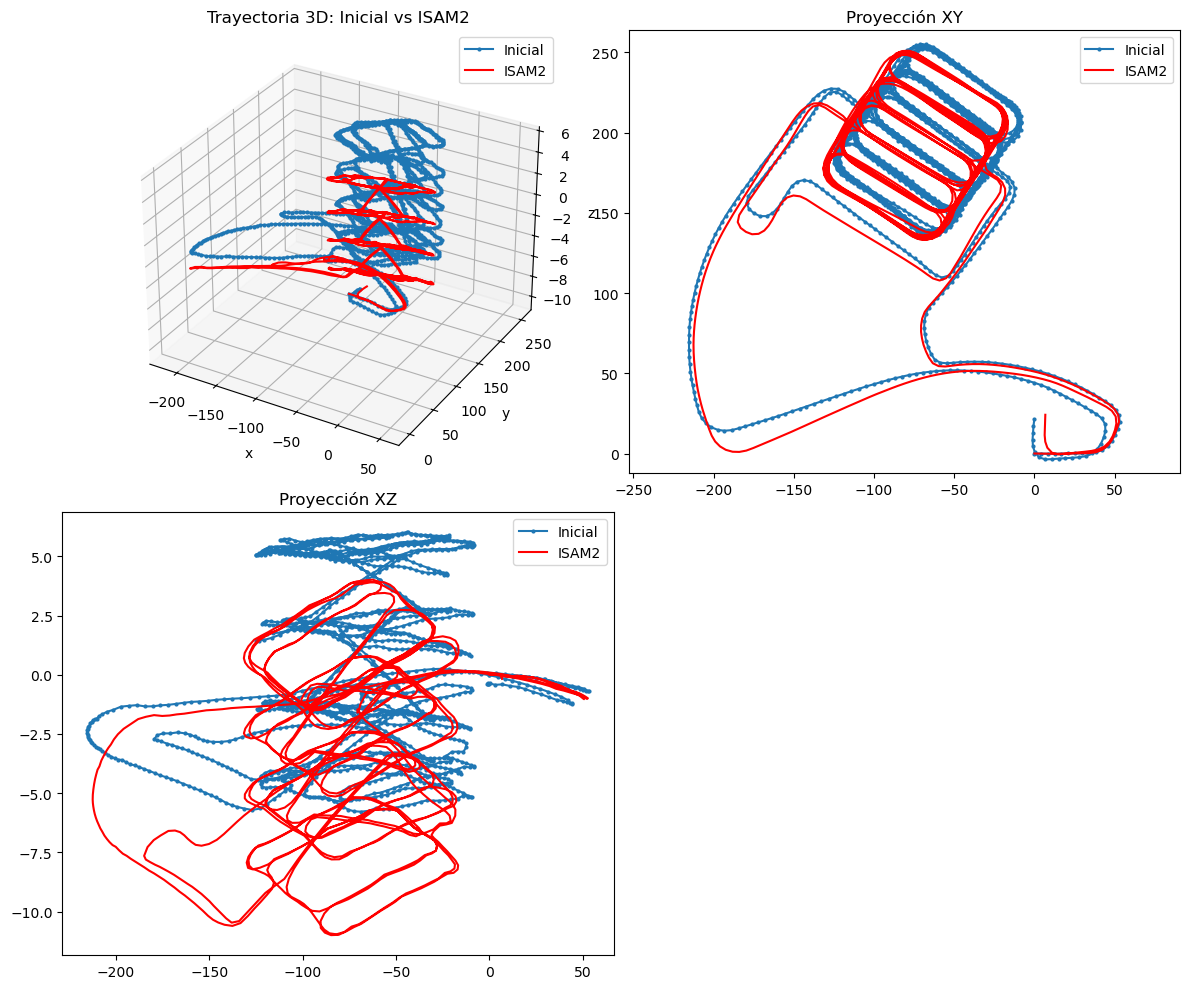

Figura guardada: garage_traj_isam2_3d.png
Error inicial (batch, con seed del archivo): 3.109141e+04
Error final (batch, con ISAM2 estimate): 2.517491e+00
Poses ISAM2 guardadas en: garage_isam2_poses.txt


In [68]:
# =======================================
# Celda 4: Extraer trayectorias y guardar figuras
# =======================================
def extract_xyz(values, ids):
    xs=[]; ys=[]; zs=[]
    for i in ids:
        try:
            p = values.atPose3(int(i))
            xs.append(p.x()); ys.append(p.y()); zs.append(p.z())
        except Exception:
            xs.append(np.nan); ys.append(np.nan); zs.append(np.nan)
    return np.array(xs), np.array(ys), np.array(zs)

x_init, y_init, z_init = extract_xyz(initial_values, ids_sorted)
x_isam, y_isam, z_isam = extract_xyz(result_isam, ids_sorted)

# Graficar 3D + proyecciones 2D
fig = plt.figure(figsize=(12,10))
ax3d = fig.add_subplot(2,2,1, projection='3d')
ax3d.plot(x_init, y_init, z_init, '-o', markersize=2, label='Inicial')
ax3d.plot(x_isam, y_isam, z_isam, '-r', markersize=2, label='ISAM2')
ax3d.set_title('Trayectoria 3D: Inicial vs ISAM2')
ax3d.set_xlabel('x'); ax3d.set_ylabel('y'); ax3d.set_zlabel('z'); ax3d.legend()

ax_xy = fig.add_subplot(2,2,2)
ax_xy.plot(x_init, y_init, '-o', markersize=2, label='Inicial')
ax_xy.plot(x_isam, y_isam, '-r', markersize=2, label='ISAM2')
ax_xy.set_title('Proyección XY'); ax_xy.axis('equal'); ax_xy.legend()

ax_xz = fig.add_subplot(2,2,3)
ax_xz.plot(x_init, z_init, '-o', markersize=2, label='Inicial')
ax_xz.plot(x_isam, z_isam, '-r', markersize=2, label='ISAM2')
ax_xz.set_title('Proyección XZ'); ax_xz.legend()

plt.tight_layout()
out_fig = 'garage_traj_isam2_3d.png'
plt.savefig(out_fig, dpi=250)
plt.show()
plt.close(fig)
print("Figura guardada:", out_fig)

# Métricas: error del grafo batch evaluado con la estimación ISAM2 final
final_error_isam = graph_batch.error(result_isam)
print(f"Error inicial (batch, con seed del archivo): {initial_error:.6e}")
print(f"Error final (batch, con ISAM2 estimate): {final_error_isam:.6e}")

# (opcional) guardar poses optimizadas a archivo .txt
out_txt = 'garage_isam2_poses.txt'
with open(out_txt, 'w') as fh:
    for i in ids_sorted:
        try:
            p = result_isam.atPose3(int(i))
            # formateo: id x y z qx qy qz qw (g2o-style qw last -> convert to qx,qy,qz,qw)
            qw = p.rotation().w(); qx = p.rotation().x(); qy = p.rotation().y(); qz = p.rotation().z()
            fh.write(f"{i} {p.x()} {p.y()} {p.z()} {qx} {qy} {qz} {qw}\n")
        except Exception:
            pass
print("Poses ISAM2 guardadas en:", out_txt)
